In [1]:
from azureml.core import Experiment, Run, Workspace
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.83


In [2]:
subscription_id = '6a0ec27b-1203-46fe-ade0-8c3003d5e4bc'
resource_group  = 'PythonSDK'
workspace_name  = 'pythonsdkworkspace'

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print('Library configuration succeeded')
except:
    print('Workspace not found')


Library configuration succeeded


In [3]:
experiment_name = 'autoMLdemo1'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

irisds = load_iris()

iris = sns.load_dataset("iris")
type(iris)

pandas.core.frame.DataFrame

In [5]:
y = iris.species
X = iris.drop('species',axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y)


In [6]:
##If we were not using 'preprocess = True' then we would have to convert to a numeric 

#Create a function to convert species to numeric
def func(x):
     if x == 'setosa':
          return 1
     elif x == 'versicolor':
          return 2
     elif x == 'virginica':
          return 3

from numpy import vectorize
vfunc = vectorize(func) #Define a vectorized function which takes a nested sequence of objects or numpy arrays as inputs

yfactTrain = vfunc(y_train)
yfactTest = vfunc(y_test)

yfactTrain = yfactTrain.reshape(len(yfactTrain))
yfactTest = yfactTest.reshape(len(yfactTest))


In [7]:
#Make sure all the features are floats
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

In [8]:
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
34,4.9,3.1,1.5,0.2
89,5.5,2.5,4.0,1.3
121,5.6,2.8,4.9,2.0
94,5.6,2.7,4.2,1.3
104,6.5,3.0,5.8,2.2


In [11]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
71,6.1,2.8,4.0,1.3
90,5.5,2.6,4.4,1.2
4,5.0,3.6,1.4,0.2
17,5.1,3.5,1.4,0.3
18,5.7,3.8,1.7,0.3


In [9]:
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.constants import Metric

##Local compute 
Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = Metric.Accuracy,
                             #primary_metric = Metric.AUCWeighted,
                             model_explainability=True, #make the models explainable
                             iteration_timeout_minutes = 12000,
                             iterations = 6,
                             #n_cross_validations = 2,
                             preprocess = False,
                             #exit_score = 0.995,
                             #blacklist_models = ['kNN','LinearSVM'],
                             X = X_train,
                             y = yfactTrain,
                             X_valid = X_test,
                             y_valid = yfactTest,
                             path='./sample_projects/automl-local-classification')

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


In [10]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_74b2853e-7e4b-4ed6-9eeb-33ee2b0401e6


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                 

In [11]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [12]:
#Breakdown of the results
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5
AUC_macro,1.00,0.99,0.99,0.95,1.00,1.00
AUC_micro,0.99,0.99,0.99,0.93,0.99,0.99
AUC_weighted,1.00,0.99,0.99,0.95,1.00,1.00
accuracy,0.96,0.93,0.93,0.71,0.96,0.96
average_precision_score_macro,0.99,0.98,0.98,0.89,0.99,0.99
average_precision_score_micro,0.99,0.99,0.97,0.89,0.99,0.99
average_precision_score_weighted,0.99,0.98,0.98,0.89,0.99,0.99
balanced_accuracy,0.96,0.93,0.93,0.71,0.96,0.96
f1_score_macro,0.96,0.93,0.93,0.64,0.96,0.96
f1_score_micro,0.96,0.93,0.93,0.71,0.96,0.96


In [13]:
#Get the best model
best_run, fitted_model = local_run.get_output()


In [14]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
autoMLdemo1,AutoML_74b2853e-7e4b-4ed6-9eeb-33ee2b0401e6_5,,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [15]:
#Test with the testing data

from sklearn.metrics import confusion_matrix, roc_curve, auc

y_pred = (fitted_model.predict(X_test))

print(accuracy_score(yfactTest, y_pred))

cm = confusion_matrix(yfactTest, y_pred)
print(cm)


0.9555555555555556
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]


### Explain the model

In [16]:
#Packages to explain the model
#! pip install azureml-interpret azureml-contrib-interpret

from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())

{'petal_length': 2.59168010904794, 'petal_width': 1.743420591183528, 'sepal_width': 0.28947191686801405, 'sepal_length': 0.22916645146613987}


In [17]:
from azureml.contrib.interpret.explanation.explanation_client import ExplanationClient
from azureml.core.run import Run
from interpret.ext.blackbox import TabularExplainer


# write code to get and split your data into train and test sets here
# write code to train your model here 

# explain predictions on your local machine
# "features" and "classes" fields are optional
explainer = TabularExplainer(fitted_model, 
                             X_train,
                             classes = ['setosa', 'versicolor', 'virginica'])

# explain overall mo

In [18]:
# explain overall model predictions (global explanation)
global_explanation = explainer.explain_global(X_test)

In [19]:
from interpret_community.widget import ExplanationDashboard
ExplanationDashboard(global_explanation, fitted_model, datasetX=X_test)

ExplanationWidget(value={'predictedY': [1, 2, 3, 2, 3, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3…

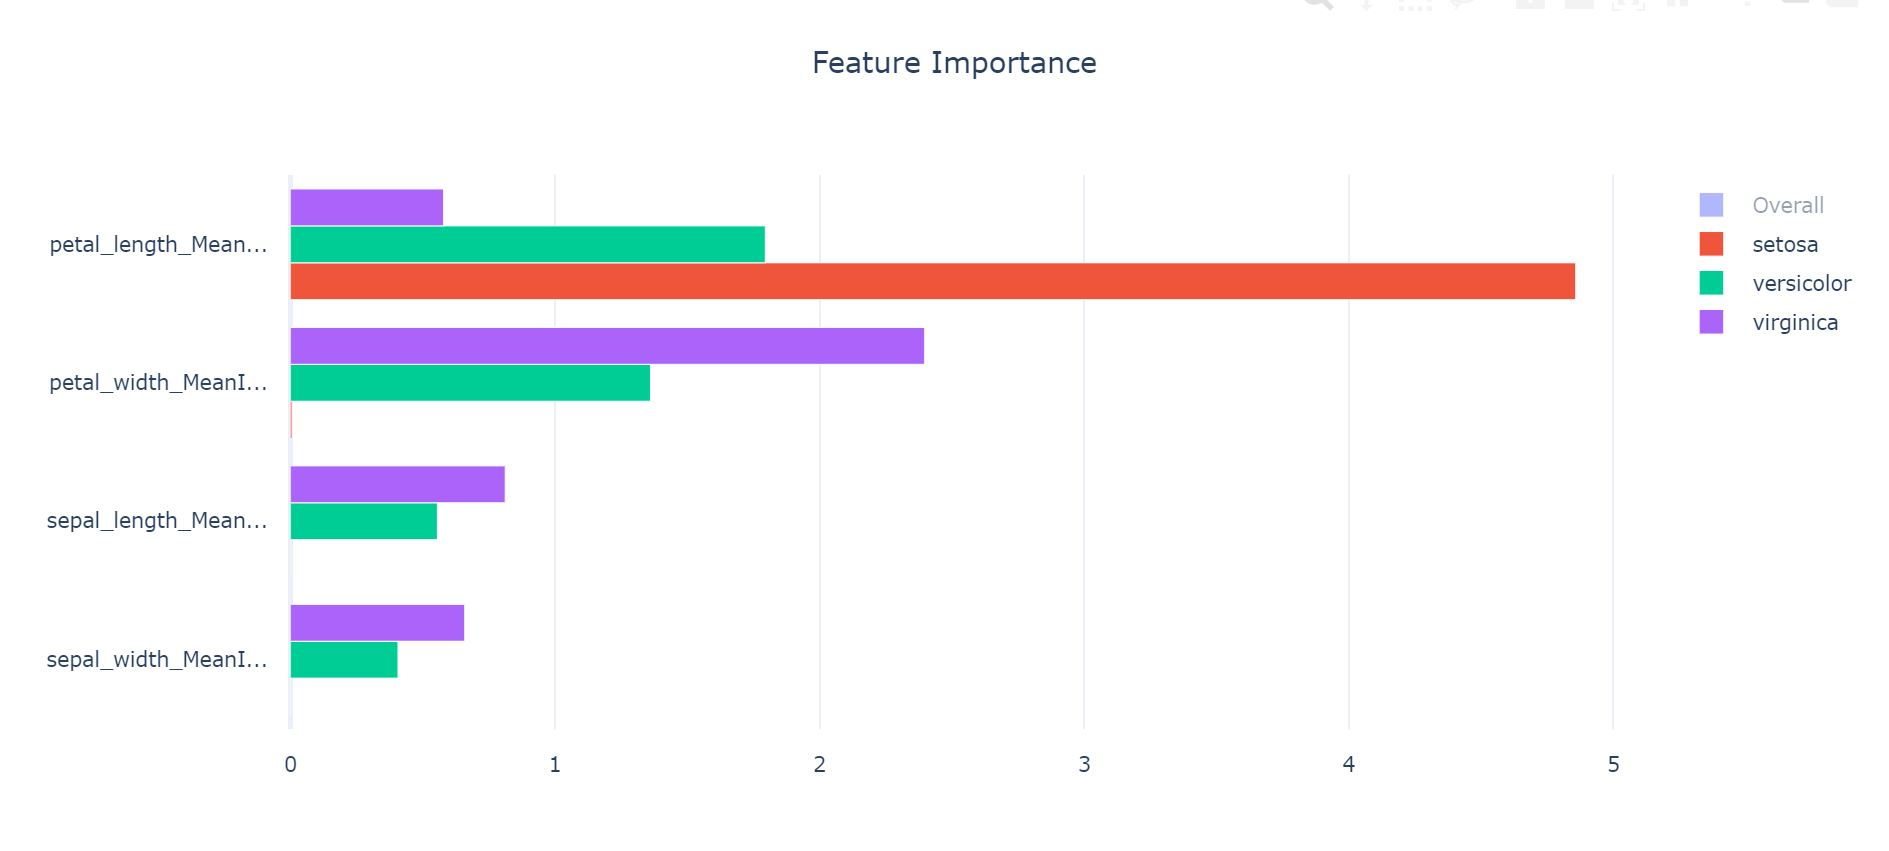

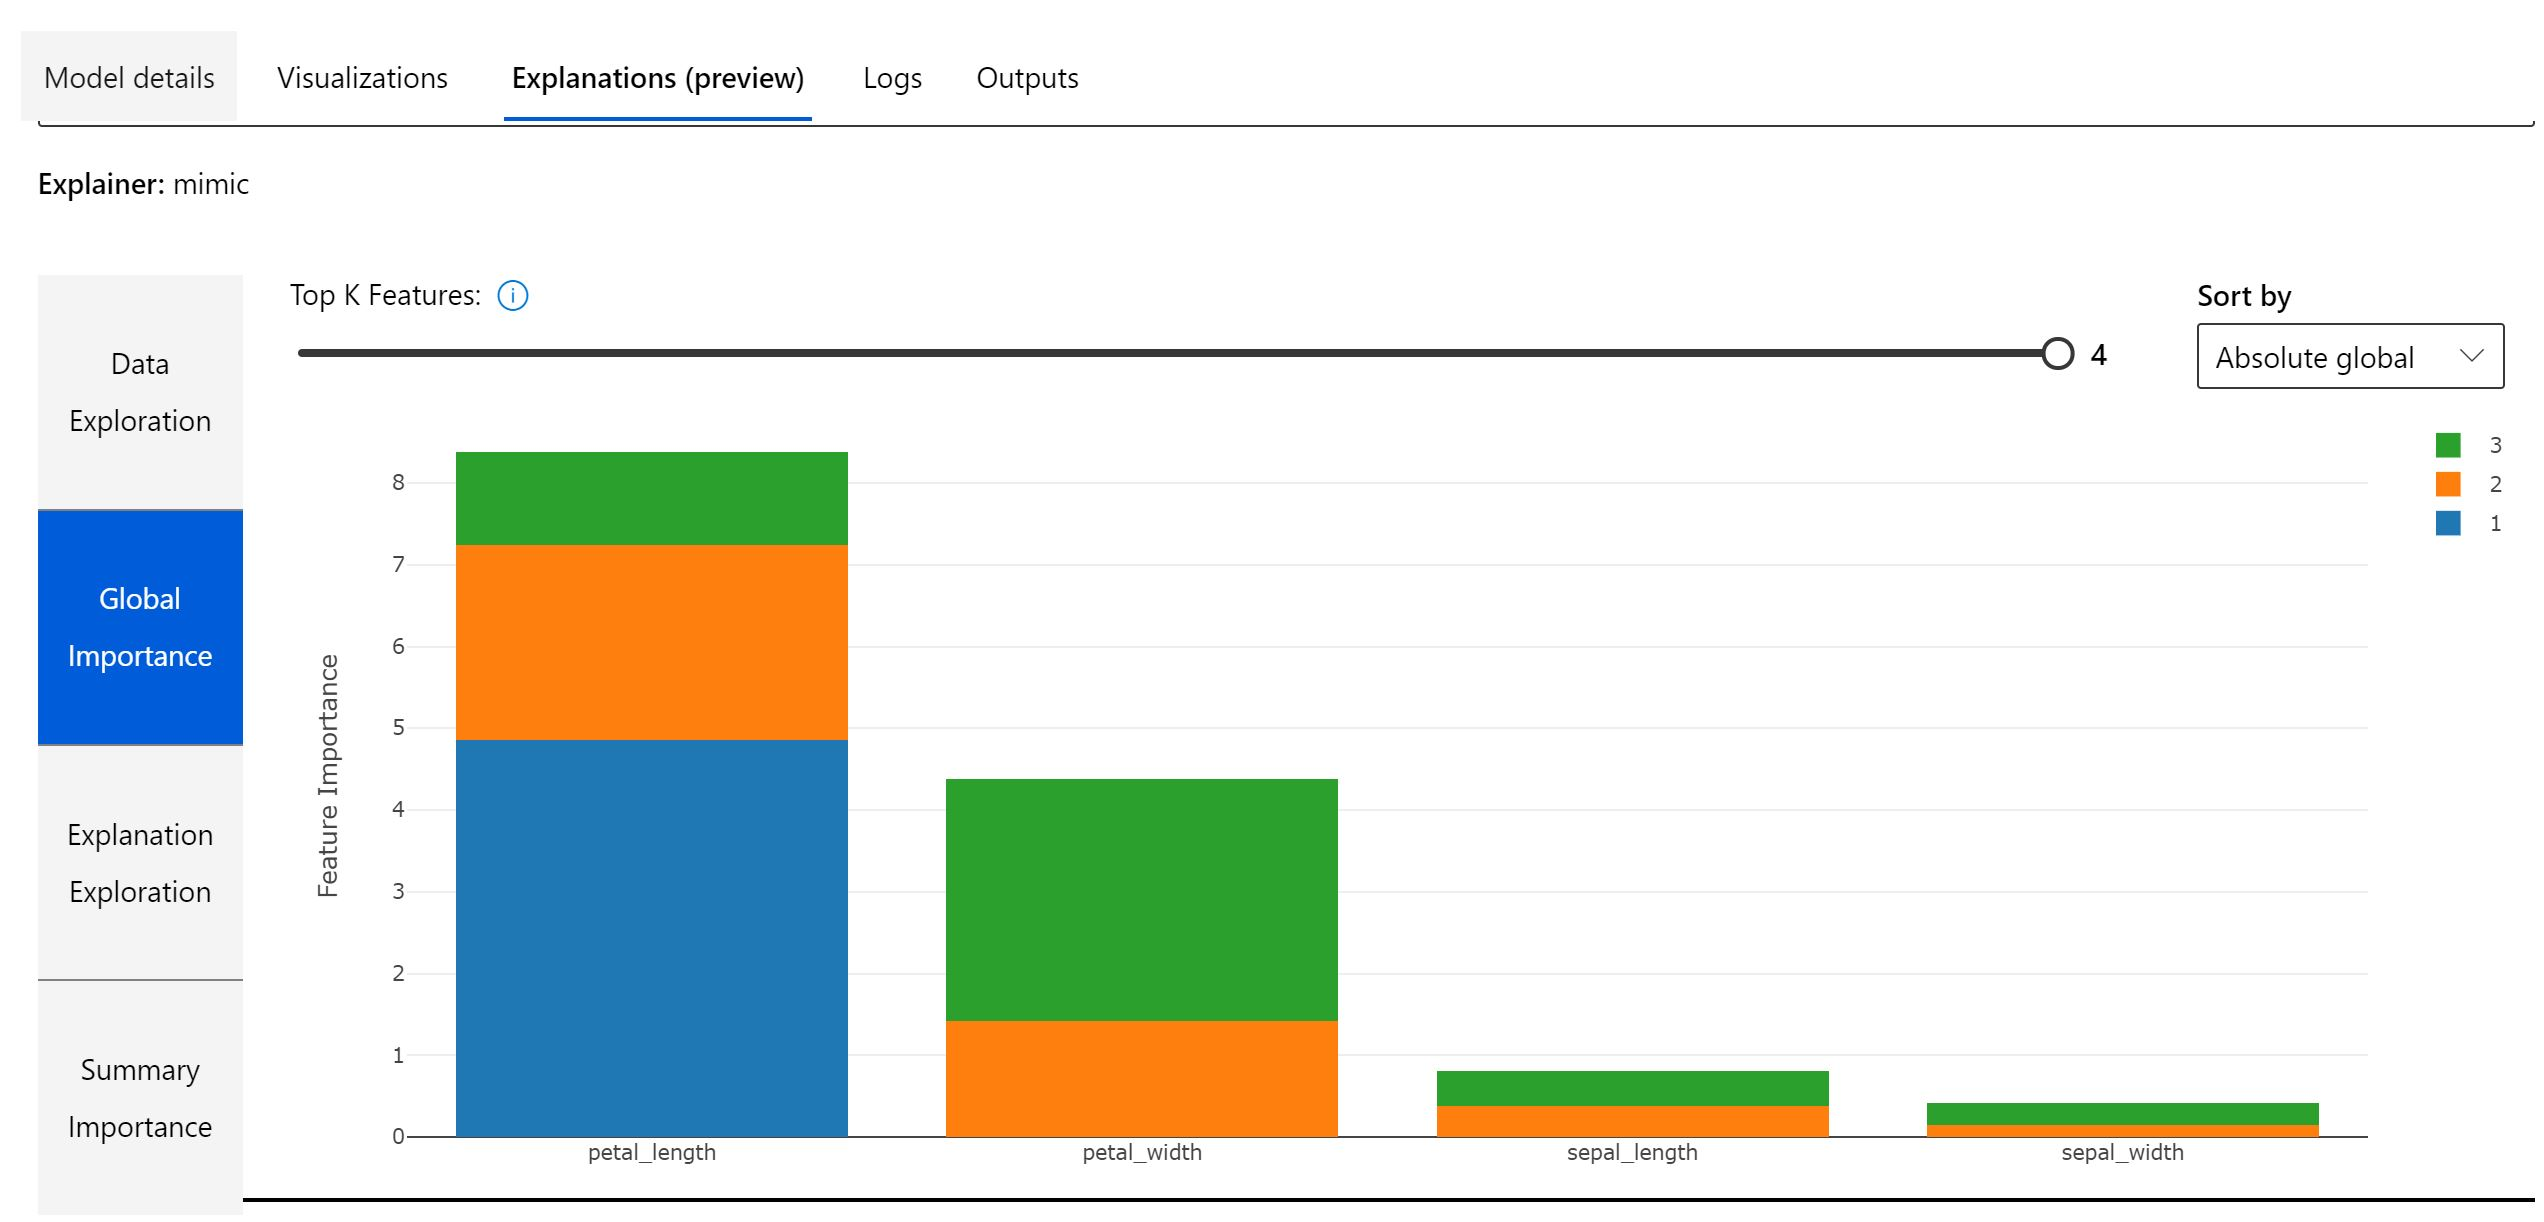